## Data Modeling and Analysis

<b>Data Processing</b>
- Standardize Data
- Train/Test Split
- Isolate Classification Labels

<b>3D Clustering Models</b> 
- Predict Water Quality Data Source
    - <i>Gaussian Mixture</i> clustering models trained using all 3 metrics
    - Calculate detailed accuracy report 
    - Return confidence in the model and probabilty ranges when interpreting new data
- Detect Water Quality Outliers
    - <i>K Means</i> clustering models trained using all 3 metrics
    - Return comparison of all characteristics of outlier data points
    
<b>2D Classification Validation</b>
- Project coliform data onto each associated metric
- Compare similarity of predicted clusters across metrics
    - Check Gaussian Mixture model as it is used for more in depth analysis

In [1]:
#import libraries

import warnings
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
#import data

data_total = pd.read_csv('data/sample_dataframe_totalcoliform.csv')
data_ecoli = pd.read_csv('data/sample_dataframe_ecoli.csv')

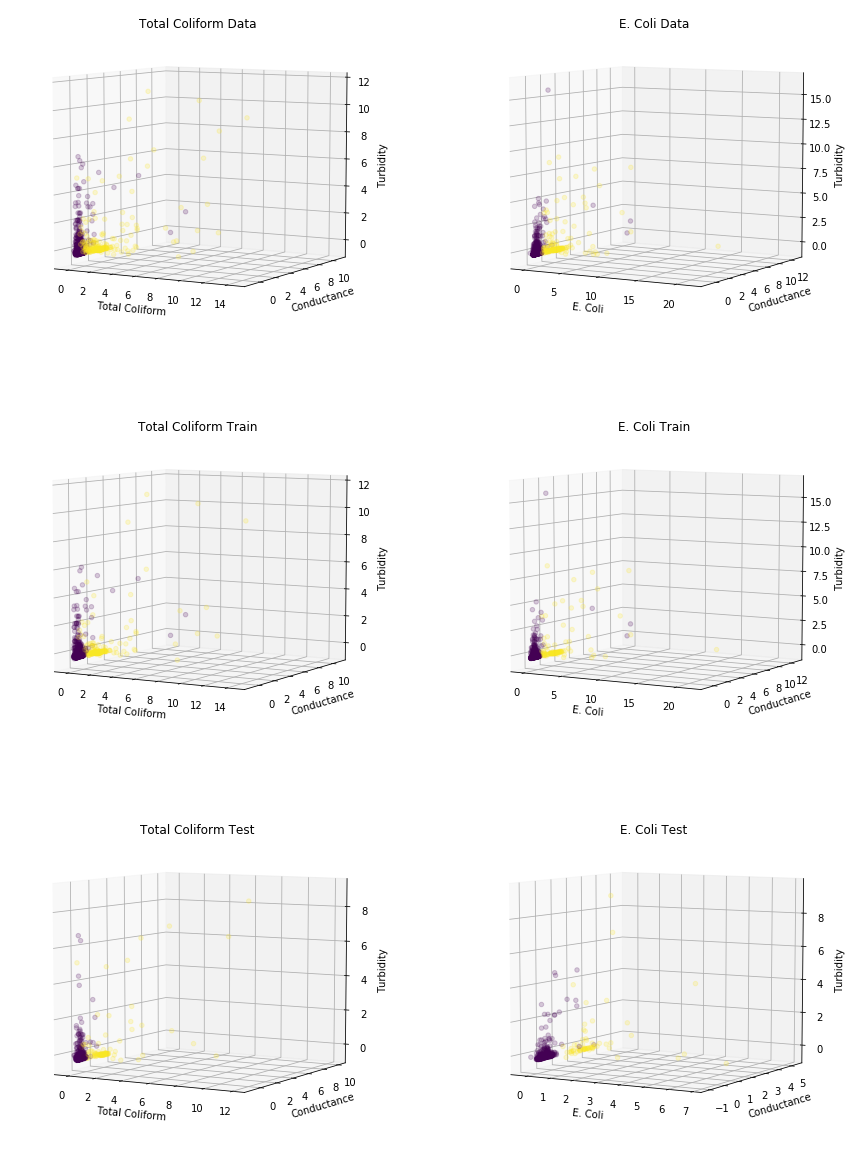

In [3]:
#standardize label and plot data

#standardizing the data prevents one metrics unit scale from dominating the model
#in the plots we see two clusters:
    #1: inner cluster near origin (chattahoochee)
    #2: outer "cluster" spread further from origin (proctor)
    #This suggests that Proctor Creek data as a whole is significantly different as an outlier from Chattahoochee River

random_state = 0
    
def processData(data):
    #returns standardized data, stores labels (standard (y1) and inverted (y2)) separate arrays
    X_raw = data[data.columns[3:]].values
    X = (X_raw - X_raw.mean(axis=0))/X_raw.std(axis=0)

    stationList = data[data.columns[1]].values
    y1 = [] #proctor creek = 1
    y2 = [] #proctor creek = 0
    
    for station in stationList:
        if station == 'USGS-02336526':
            y1.append(1)
            y2.append(0)
        else:
            y1.append(0)
            y2.append(1)
    
    np.random.seed(random_state)
    X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.35)
    
    y2_train = []
    y2_test = []
    
    for label in y1_train:
        y2_train.append( -1*label + 1)
    for label in y1_test:
        y2_test.append( -1*label + 1)
        
    return X, X_train, X_test, y1, y1_train, y1_test, y2, y2_train, y2_test
                
X_total, X_total_train, X_total_test, y1_total, y1_total_train, y1_total_test, y2_total, y2_total_train, y2_total_test = processData(data_total)
X_ecoli, X_ecoli_train, X_ecoli_test, y1_ecoli, y1_ecoli_train, y1_ecoli_test, y2_ecoli, y2_total_ecoli, y2_ecoli_test = processData(data_ecoli)

def plot3D(X, y, ax, metric, modifier=''):
    #plots data in 3 dimensions
    ax.scatter(X[:,0], X[:,1], X[:,2], c=y, cmap='viridis', alpha=0.2)
    ax.view_init(elev=7)
    ax.set_title(metric + ' ' + modifier)
    ax.set_xlabel(metric)
    ax.set_ylabel('Conductance')
    ax.set_zlabel('Turbidity')

fig = plt.figure(figsize=(15, 21))
ax1 = fig.add_subplot(321, projection='3d')
ax2 = fig.add_subplot(322, projection='3d')
ax3 = fig.add_subplot(323, projection='3d')
ax4 = fig.add_subplot(324, projection='3d')
ax5 = fig.add_subplot(325, projection='3d')
ax6 = fig.add_subplot(326, projection='3d')
    
plot3D(X_total, y1_total, ax1, 'Total Coliform', 'Data')
plot3D(X_total_train, y1_total_train, ax3, 'Total Coliform', 'Train')
plot3D(X_total_test, y1_total_test, ax5, 'Total Coliform', 'Test')
plot3D(X_ecoli, y1_ecoli, ax2, 'E. Coli', 'Data')
plot3D(X_ecoli_train, y1_ecoli_train, ax4, 'E. Coli', 'Train')
plot3D(X_ecoli_test, y1_ecoli_test, ax6, 'E. Coli', 'Test')


                     precision    recall  f1-score   support

      Proctor Creek       0.99      0.92      0.95       879
Chattahoochee River       0.73      0.95      0.83       209

           accuracy                           0.92      1088
          macro avg       0.86      0.93      0.89      1088
       weighted avg       0.94      0.92      0.93      1088

                     precision    recall  f1-score   support

      Proctor Creek       0.99      0.94      0.96       837
Chattahoochee River       0.68      0.97      0.80       117

           accuracy                           0.94       954
          macro avg       0.84      0.95      0.88       954
       weighted avg       0.96      0.94      0.94       954



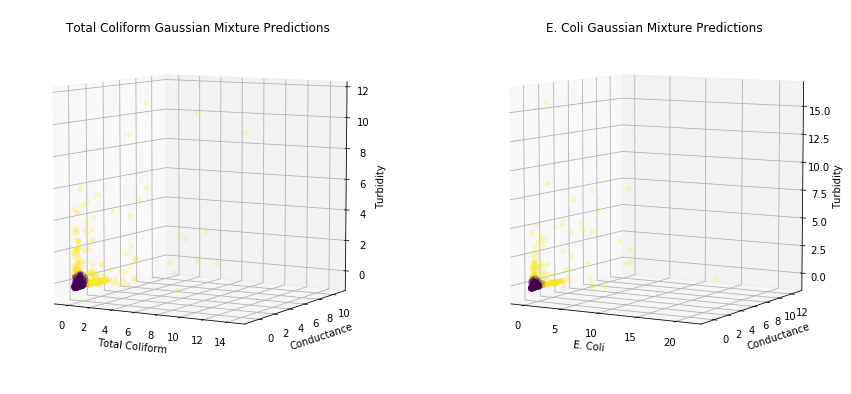

In [4]:
#Gaussian Mixture clustering model - complex modeling 3 dimensional data with 2 clusters

#Pros: probabilities of cluster distributions can be accessed, better accuracy
#Cons: tighter inner circle than kmeans (lower threshold for what an 'outlier' is)

n_clusters = 2

def GM(X, y):
    #creates a gaussian mixture model for a 3 dimensional matrix
    #returns the model, predictions, and testing class report
    model = GaussianMixture(n_components=n_clusters, random_state=random_state, covariance_type='spherical')
    model.fit(X)
    y_predict = model.predict(X)
    
    tcr = classification_report(y, y_predict, target_names=['Proctor Creek','Chattahoochee River'])
    print(tcr)
    return model, y_predict, tcr

model_GM3d_total, y_GM3d_total, tcr_GM3d_total = GM(X_total_train, y1_total_train)
model_GM3d_ecoli, y_GM3d_ecoli, tcr_GM3d_ecoli = GM(X_ecoli_train, y1_ecoli_train)

fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

plot3D(X_total_train, y_GM3d_total, ax1, 'Total Coliform', 'Gaussian Mixture Predictions')
plot3D(X_ecoli_train, y_GM3d_ecoli, ax2, 'E. Coli', 'Gaussian Mixture Predictions')

                     precision    recall  f1-score   support

      Proctor Creek       0.99      0.92      0.95       879
Chattahoochee River       0.73      0.95      0.83       209

           accuracy                           0.92      1088
          macro avg       0.86      0.93      0.89      1088
       weighted avg       0.94      0.92      0.93      1088

                     precision    recall  f1-score   support

      Proctor Creek       0.99      0.94      0.96       837
Chattahoochee River       0.68      0.97      0.80       117

           accuracy                           0.94       954
          macro avg       0.84      0.95      0.88       954
       weighted avg       0.96      0.94      0.94       954



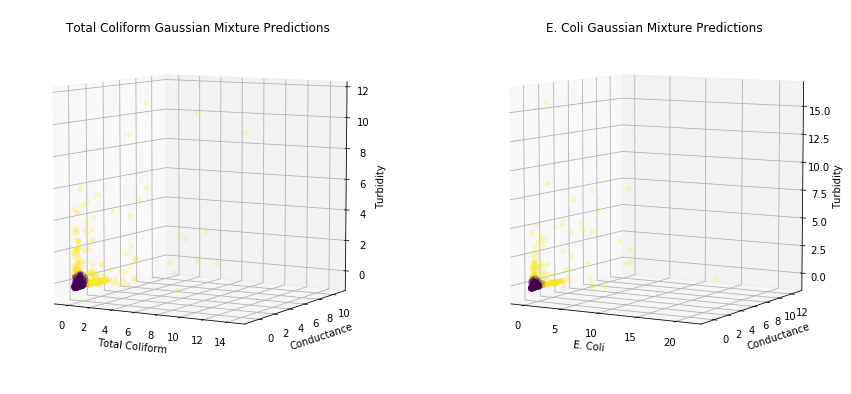

In [5]:
#Predictive Capabilities

#train model on training data, test for accurracy of clusters
#use cluster probability distributions in model to predict on test data

n_clusters = 2

def GM(X, y):
    #creates a gaussian mixture model for a 3 dimensional matrix
    #returns the model, predictions, and testing class report
    model = GaussianMixture(n_components=n_clusters, random_state=random_state, covariance_type='spherical')
    model.fit(X)
    y_predict = model.predict(X)
    
    tcr = classification_report(y, y_predict, target_names=['Proctor Creek','Chattahoochee River'])
    print(tcr)
    return model, y_predict, tcr

model_GM3d_total, y_GM3d_total, tcr_GM3d_total = GM(X_total_train, y1_total_train)
model_GM3d_ecoli, y_GM3d_ecoli, tcr_GM3d_ecoli = GM(X_ecoli_train, y1_ecoli_train)

fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

plot3D(X_total_train, y_GM3d_total, ax1, 'Total Coliform', 'Gaussian Mixture Predictions')
plot3D(X_ecoli_train, y_GM3d_ecoli, ax2, 'E. Coli', 'Gaussian Mixture Predictions')

                     precision    recall  f1-score   support

      Proctor Creek       0.98      0.92      0.95       479
Chattahoochee River       0.73      0.94      0.82       108

           accuracy                           0.93       587
          macro avg       0.86      0.93      0.89       587
       weighted avg       0.94      0.93      0.93       587

                     precision    recall  f1-score   support

      Proctor Creek       1.00      0.93      0.96       446
Chattahoochee River       0.68      0.99      0.80        69

           accuracy                           0.94       515
          macro avg       0.84      0.96      0.88       515
       weighted avg       0.96      0.94      0.94       515



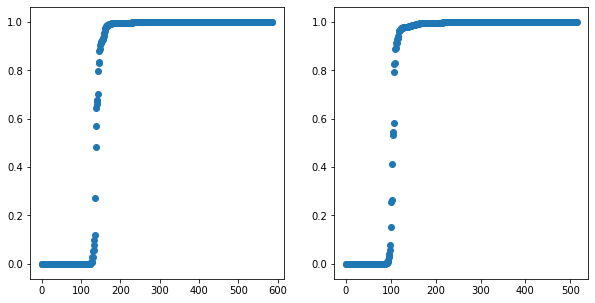

In [6]:
#find probabilities of test data

y_GM3d_total_test = model_GM3d_total.predict(X_total_test)
GM3d_probs_total_test = model_GM3d_total.predict_proba(X_total_test)
GM3d_probs_total_test_sort = np.sort(GM3d_probs_total_test[:,0])

y_GM3d_ecoli_test = model_GM3d_ecoli.predict(X_ecoli_test)
GM3d_probs_ecoli_test = model_GM3d_total.predict_proba(X_ecoli_test)
GM3d_probs_ecoli_test_sort = np.sort(GM3d_probs_ecoli_test[:,0])

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(range(len(GM3d_probs_total_test_sort)), GM3d_probs_total_test_sort)
ax2.scatter(range(len(GM3d_probs_ecoli_test_sort)), GM3d_probs_ecoli_test_sort)

tcr_GM3d_total_test = classification_report(y1_total_test, y_GM3d_total_test, target_names=['Proctor Creek','Chattahoochee River'])
print(tcr_GM3d_total_test)

tcr_GM3d_ecoli_test = classification_report(y1_ecoli_test, y_GM3d_ecoli_test, target_names=['Proctor Creek','Chattahoochee River'])
print(tcr_GM3d_ecoli_test)

                     precision    recall  f1-score   support

      Proctor Creek       0.32      0.01      0.02      1358
Chattahoochee River       0.18      0.91      0.29       317

           accuracy                           0.18      1675
          macro avg       0.25      0.46      0.16      1675
       weighted avg       0.29      0.18      0.07      1675

                     precision    recall  f1-score   support

      Proctor Creek       0.89      0.99      0.94      1283
Chattahoochee River       0.70      0.16      0.26       186

           accuracy                           0.88      1469
          macro avg       0.79      0.58      0.60      1469
       weighted avg       0.87      0.88      0.85      1469



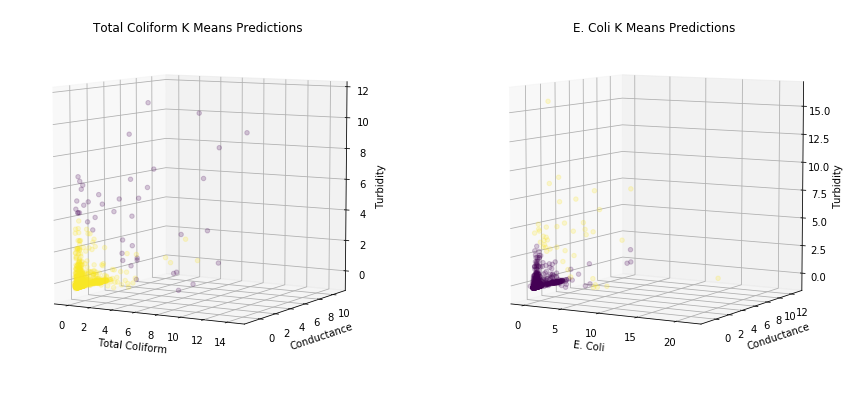

In [7]:
#K Means Mixture clustering model - basic modeling 3 dimensional data with 2 clusters

#Pros: less parameters, 'weaker' clusters (higher anomaly detection threshold)
#Cons: less information stored in model, lower clustering accuracy 

def KM(X, y):
    #creates a k means model for a 3 dimensional matrix
    #returns the model, predictions, and testing class report
    model = KMeans(n_clusters=n_clusters, random_state=random_state)
    model.fit(X)
    y_predict = model.predict(X)
    
    tcr = classification_report(y, y_predict, target_names=['Proctor Creek','Chattahoochee River'])
    print(tcr)
    return model, y_predict, tcr

model_KM3d_total, y_KM3d_total, tcr_KM3d_total = KM(X_total, y1_total)
model_KM3d_ecoli, y_KM3d_ecoli, tcr_KM3d_ecoli = KM(X_ecoli, y1_ecoli)

fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

plot3D(X_total, y_KM3d_total, ax1, 'Total Coliform', 'K Means Predictions')
plot3D(X_ecoli, y_KM3d_ecoli, ax2, 'E. Coli', 'K Means Predictions')

In [8]:
#K Means Mixture clustering model
#creates pandas subset of initial dataframe containing identified outliers

index_total = []
index_ecoli = []


for i, label in enumerate(y_KM3d_total):
    if label == 0:
        index_total.append(i)

for i, label in enumerate(y_KM3d_ecoli):
    if label == 1:
        index_ecoli.append(i)
        
outliers_total = data_total.iloc[index_total]
outliers_ecoli = data_ecoli.iloc[index_ecoli]

print('{} outliers identified in total coliform data'.format(len(index_total)))
print('{} outliers identified in E. Coli data'.format(len(index_ecoli)))

44 outliers identified in total coliform data
43 outliers identified in E. Coli data


In [9]:
#poor accuracy in total coliform may mean inverted labels

y2_KM3d_total = []
for i in range(len(y_KM3d_total)):
    y2_KM3d_total.append( -1*y_KM3d_total[i] + 1)

tcr_total_KM2d = classification_report(y1_total, y2_KM3d_total, target_names=['Proctor Creek','Chattahoochee River'])

print('KM, Total:\n' + tcr_total_KM2d + '\n')

KM, Total:
                     precision    recall  f1-score   support

      Proctor Creek       0.82      0.99      0.90      1358
Chattahoochee River       0.68      0.09      0.17       317

           accuracy                           0.82      1675
          macro avg       0.75      0.54      0.53      1675
       weighted avg       0.80      0.82      0.76      1675




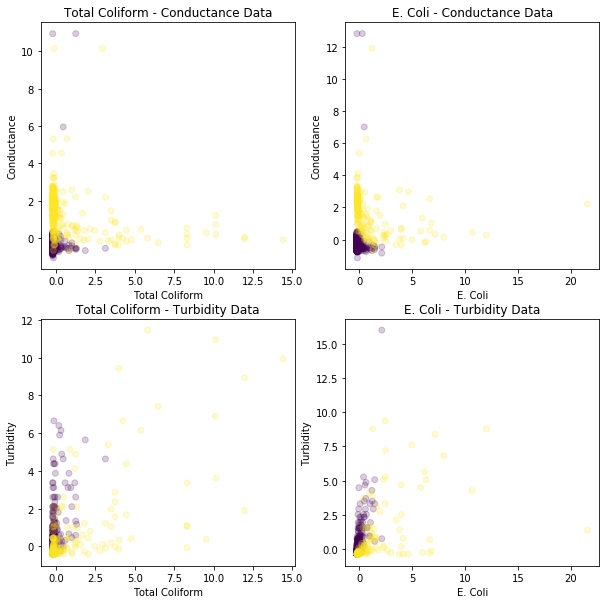

In [10]:
#plotting 2d projections data

#simplifies data into two dimensions. potentially remove confounding information between turbidity and conductance
#visualize and cluster coliform data versus individual metrics

def plot2D(x1, x2, y, ax, metric1, metric2, modifier=''):
    #plots data in 3 dimensions
    ax.scatter(x1, x2, c=y, cmap='viridis', alpha=0.2)
    ax.set_title(metric1 + ' - ' + metric2 + ' ' + modifier)
    ax.set_xlabel(metric1)
    ax.set_ylabel(metric2)

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
    
plot2D(X_total[:,0], X_total[:,1], y1_total, ax1, 'Total Coliform', 'Conductance', 'Data')
plot2D(X_total[:,0], X_total[:,2], y1_total, ax3, 'Total Coliform', 'Turbidity', 'Data')
plot2D(X_ecoli[:,0], X_ecoli[:,1], y1_ecoli, ax2, 'E. Coli', 'Conductance', 'Data')
plot2D(X_ecoli[:,0], X_ecoli[:,2], y1_ecoli, ax4, 'E. Coli', 'Turbidity', 'Data')

                     precision    recall  f1-score   support

      Proctor Creek       0.98      0.99      0.98      1358
Chattahoochee River       0.94      0.92      0.93       317

           accuracy                           0.97      1675
          macro avg       0.96      0.96      0.96      1675
       weighted avg       0.97      0.97      0.97      1675

                     precision    recall  f1-score   support

      Proctor Creek       0.85      0.82      0.83      1358
Chattahoochee River       0.32      0.36      0.34       317

           accuracy                           0.73      1675
          macro avg       0.58      0.59      0.59      1675
       weighted avg       0.75      0.73      0.74      1675

                     precision    recall  f1-score   support

      Proctor Creek       1.00      0.98      0.99      1283
Chattahoochee River       0.89      0.98      0.93       186

           accuracy                           0.98      1469
          macro 

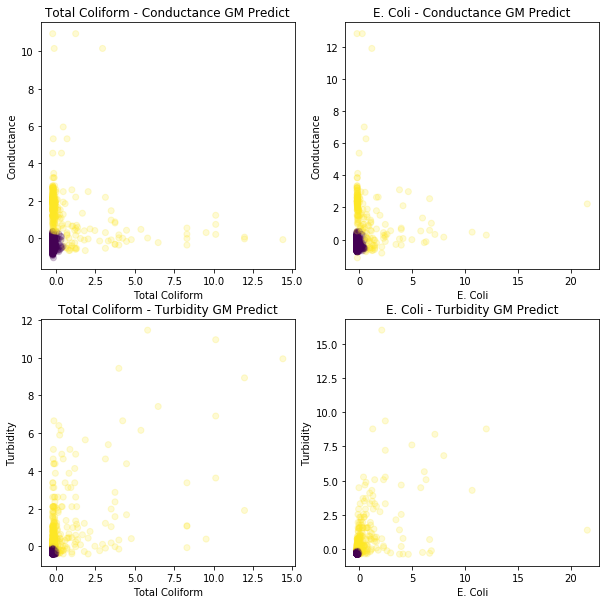

In [11]:
#Gaussian Mixture clustering model - modeling 2 dimensional data with 2 clusters

model_GM2d_total_c, y_GM2d_total_c, tcr_GM2d_total_c = GM(X_total[:,:2], y1_total)
model_GM2d_total_t, y_GM2d_total_t, tcr_GM2d_total_t = GM(X_total[:, np.r_[0,2]], y1_total)
model_GM2d_ecoli_c, y_GM2d_ecoli_c, tcr_GM2d_ecoli_c = GM(X_ecoli[:,:2], y1_ecoli)
model_GM2d_ecoli_t, y_GM2d_ecoli_t, tcr_GM2d_ecoli_t = GM(X_ecoli[:, np.r_[0,2]], y1_ecoli)

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

plot2D(X_total[:,0], X_total[:,1], y_GM2d_total_c, ax1, 'Total Coliform', 'Conductance', 'GM Predict')
plot2D(X_total[:,0], X_total[:,2], y_GM2d_total_t, ax3, 'Total Coliform', 'Turbidity', 'GM Predict')
plot2D(X_ecoli[:,0], X_ecoli[:,1], y_GM2d_ecoli_c, ax2, 'E. Coli', 'Conductance', 'GM Predict')
plot2D(X_ecoli[:,0], X_ecoli[:,2], y_GM2d_ecoli_t, ax4, 'E. Coli', 'Turbidity', 'GM Predict')

In [12]:
#Gaussian Mixture 2d Predictions validation
#are the 2d cluster models picking the same points in each axis

tcr_total_GM2d = classification_report(y_GM2d_total_c, y_GM2d_total_t, target_names=['Conductance','Turbidity'])
tcr_ecoli_GM2d = classification_report(y_GM2d_ecoli_c, y_GM2d_ecoli_t, target_names=['Conductance','Turbidity'])

print('GM')
print('Total:\n' + tcr_total_GM2d + '\n')
print('E. Coli:\n' + tcr_ecoli_GM2d + '\n')

GM
Total:
              precision    recall  f1-score   support

 Conductance       0.85      0.82      0.83      1364
   Turbidity       0.31      0.36      0.33       311

    accuracy                           0.73      1675
   macro avg       0.58      0.59      0.58      1675
weighted avg       0.75      0.73      0.74      1675


E. Coli:
              precision    recall  f1-score   support

 Conductance       0.91      0.80      0.86      1265
   Turbidity       0.31      0.53      0.39       204

    accuracy                           0.77      1469
   macro avg       0.61      0.67      0.62      1469
weighted avg       0.83      0.77      0.79      1469




<b>Summary</b>


- <u>3D Models:</u> Both 3d models have excellent accuracy. This shows that Proctor Creek is significantly, wholisticaly different than the Chattahoochee River. The models serve different purposes and can be used for different analysis. Additionally, the models both lack in precision for Chatahoochee River. The model has difficulty separating outlier Chattahoochee River data. All outliers are being called Proctor Creek, this gives more credibility to the initial statement that Proctor Creek has significnantly worse water quality than the Chattahoochee River.
    - <i>KMeans:</i> Provides 'stricter' requirements for anomaly detection. Allows prioritization for followup at poorer quality locations
    - <i>Gaussian Mixture:</i> Provides more data for analysis of model including probabilities for forecasting
    
    
- <u>2D Models</u> The 2d models are equally capable at clustering the data as the 3d models, but their main purpose for us is model validation. When projected onto each secondary metric axis, the 2d projections have good "accuracy" in selecting the same points - this shows that neither turbidity nor conductance are confounding variables


- <u>Conclusion</u>
    - Use KMeans to generate list of outlier points to be compared and contrasted as deliverable
    - Use Gaussian Mixtures to generate probabilities to give prediction confidence on new points as deliverable
    - 2d models mostly just for validation: Check Gaussian Mixture more because harsher threshhold and more real analysis